# Emission Frequency Estimation
In this notebook we consider an emission frequency estimation problem. A source emits a binary signal with a certain frequency which we would like to estimate. 

We can solve it in exactly the same way than the biased coin flipping problem. 


* **Setting**: A source emits a binary signal $x_i\in\{0,1\}$. 
* **Problem**: We'd like to estimate the probability $\theta$ that the source will emit a $1$.
* **Prior**: We have no prior knowledge of the emission frequency, we'll use a uniform prior on $\theta$ with density $p(\theta)=1$. 

* **Likelihood**: $$x_i| \theta \sim Bernoulli(\theta),$$ or in other words $$p(x_i=1| \theta) = \theta\ , $p(x_i=0| \theta) = 1-\theta . $$ 

We'll create a source with a known frequency and generate some observations. We'll then set up a pymc3 model and estimate the posterior using mcmc. 

In [1]:
import numpy as np
import pymc3 as pm
# create the true frequency of emission we'll want to estimate
real_freq = 0.3
# create a pymc3 distribution (note the .dist: it's necessary outside a pm.Model() context) 
x = pm.Bernoulli.dist(p=real_freq)

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [10]:
#Draw some random samples from the distribution
observations = x.random(size=20)
print(observations)

[0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0]


In [11]:
with pm.Model() as emission_model:
    # Specify the uniform prior for emission frequency theta
    theta = pm.Uniform('theta', lower=0., upper=1.)
    # Specify the likelihood for the signal x_i | theta
    # Specify observations
    x_i = pm.Bernoulli('x_i', p=theta, observed=observations)
    # Sample from posterior distribution
    trace = pm.sample(1000, tune=500, cores=4)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 5907.12draws/s]
The acceptance probability does not match the target. It is 0.8941887731598815, but should be close to 0.8. Try to increase the number of tuning steps.


posterior samples from theta:  (4000,)


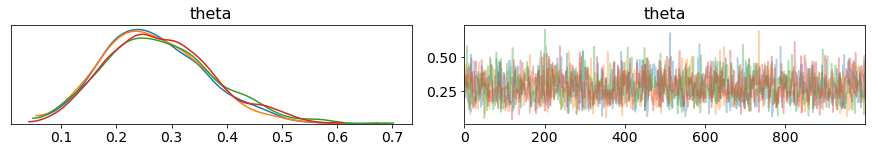

In [12]:
#inspect the result
print("posterior samples from theta: ", trace['theta'].shape)
pm.traceplot(trace);

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f812f5e85f8>],
      dtype=object)

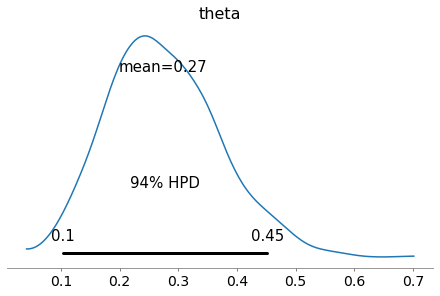

In [13]:
pm.plot_posterior(trace)

Perfect, we have an estimate and a credibility interval.

Now let's take a look at how the posterior changes as the number of observations increases

In [16]:
def make_posterior_plot(observations, n_observations):
    with pm.Model() as emission_model:
        # Specify the uniform prior for emission frequency theta
        theta = pm.Uniform('theta', lower=0., upper=1.)
        # Specify the likelihood for the signal x_i | theta
        # Specify observations
        x_i = pm.Bernoulli('x_i', p=theta, observed=observations[:n_observations])
        # Sample from posterior distribution
        trace = pm.sample(1000, tune=500, cores=4)
    return pm.plot_posterior(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 5909.23draws/s]
The acceptance probability does not match the target. It is 0.8909351212782275, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 5920.44draws/s]
The acceptance probability does not match the target. It is 0.8790097681166944, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8991734810033775, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [

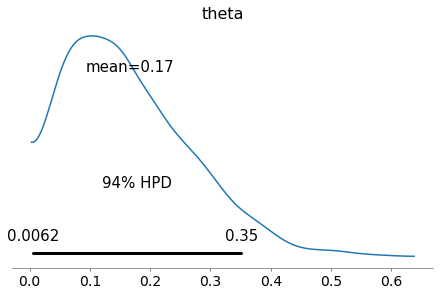

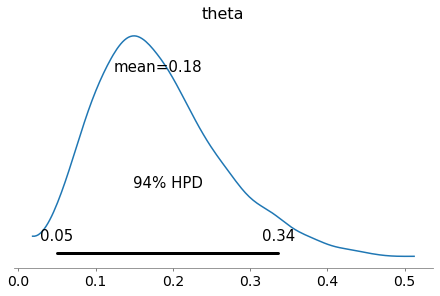

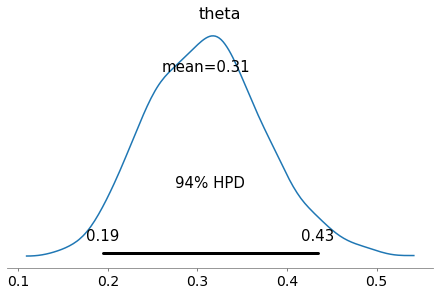

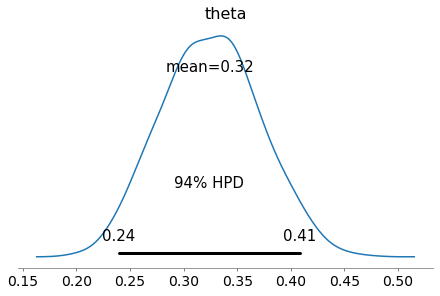

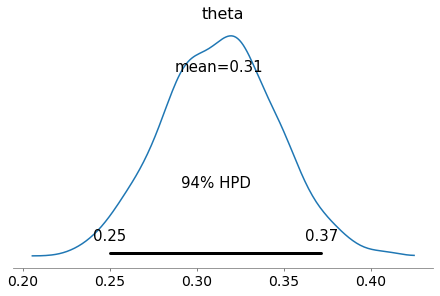

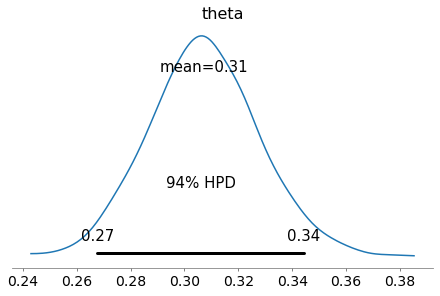

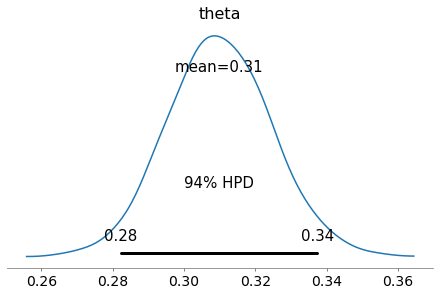

In [19]:
observations = x.random(size=1000)
for n in [10, 20, 50, 100, 200, 500, 1000]:
    make_posterior_plot(observations, n)

We see the mean converging and the credible interval tightening.

For this simple example we can compute the posterior analytically.
$p(\theta|x_{n-1},\dots,x_0)\propto (1-\theta)^{n-y}\theta^y$, where $y=\sum_{i=0}^{n-1}x_i$

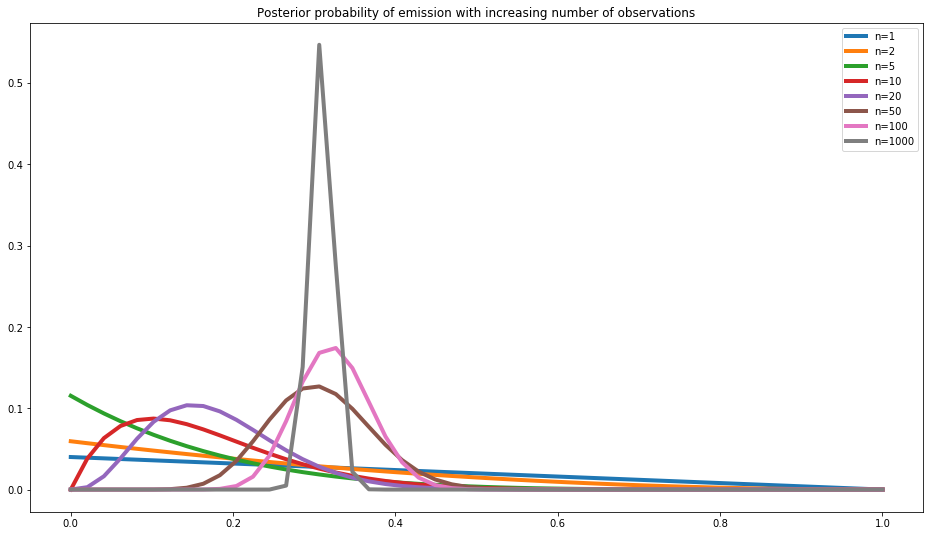

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(16,9))
for n in [1, 2, 5, 10, 20, 50, 100, 1000]:
    obs = observations[:n]
    y = np.sum(obs)
    thetas = np.linspace(0,1)
    posterior = (1-thetas)**(n-y) * thetas**y
    normalization = posterior.sum()
    posterior/=normalization
    plt.plot(thetas, posterior, label=f'n={n}', lw=4);
plt.title('Posterior probability of emission with increasing number of observations')
plt.legend();